# Lab Course: Distributed Data Analytics Exercise Sheet 10
**Submitted by: Mohit Bansal**

**Student ID: 279314**

### Exercise 1: Recommender System from scratch ( 10 points)

In this exercise we supposed to implement matrices factorization technique for recommendation system and we will be starting by explanation of how this thing work.

Most MF models are based on the latent factor model. It is the most accurate approach to reducing the problem of sparsity in the database of a recommendation system, some studies have used techniques for reducing dimensionality. Singular Value Decomposition (SVD) and Principal Component Analysis (PCA) are well-established techniques for identifying latent factors in the field of information retrieval to address the challenges of filtering.
Collaborative (FC)

First, we have a set of users U and a set of items I. Let X be the size matrix (m x n) that contains all the notes that the users assigned to the articles (rating matrix). Now, the latent characteristics would be discovered.

Our task is therefore to find two matrices, P (m x f) and Q (f x n) f is the latent factor (a positive integer such that f <m x n), so their product is roughly equivalent to R (m x n)

 In this way, matrix factorization models map users and elements into a joint latent factor space of dimensionality f, interactions with user elements are modeled as internal products in that space.
We have trained the problem this way:



#### Step 1: Import Libraries

In [7]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col
import numpy as np
from pyspark.sql.functions import countDistinct, udf, lit
import pandas as pd
from pyspark.sql.functions import rand

spark = SparkSession \
         .builder \
         .appName("Python Spark - Testing the Waters") \
         .config("spark.some.config.option", "some-value") \
         .getOrCreate()
 
sc = spark.sparkContext
sqlCtx = SQLContext(sc)

#### Step 2: Read Data

Read the ratings.dat dataset

In [10]:
def readData():
    path = '/Users/mundanemohit/Google Drive/My Work/MSc. Data Analytics/3114 Distributed Data Analytics/Excercises/Ex09/ml-10M100K/'

    # Read Data
    ratingDF = spark.read.csv(path + 'ratings.dat', sep=':')
    ratingDF = ratingDF.drop('_c1', '_c3', '_c5')
    ratingDF = ratingDF.selectExpr('_c0 as UserID', '_c2 as MovieID', '_c4 as Rating')
    ratingDF = ratingDF.withColumn('UserID', col('UserID').cast("int"))             \
                       .withColumn('MovieID', col('MovieID').cast("int"))           \
                       .withColumn('Rating', col('Rating').cast("double"))
    ratingDF = ratingDF.distinct()
    ratingDF = ratingDF.sample(0.01).cache()
    userDF = ratingDF.select('UserID').distinct().count()
    movieDF = ratingDF.select('MovieID').distinct().count() 
    ratingDF.show(5)
    ratingDF.printSchema()
    return ratingDF, userDF, movieDF

ratingDF, nU, nV = readData()

+------+-------+------+
|UserID|MovieID|Rating|
+------+-------+------+
|    30|    592|   5.0|
|   192|     31|   3.0|
|   470|   6807|   4.5|
|   564|    595|   5.0|
|   655|    455|   1.0|
+------+-------+------+
only showing top 5 rows

root
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Rating: double (nullable = true)



### Step 3: Training

To break down the training step, we create a class which takes the following input parameters:

* **R**: The user-item rating matrix
2. **Rank**: No. of latent dimensions
3.    **Alpha**: Learning Rate
4.    **Reg**: Regularization parameter
5.    **Iter**: No. of iterations

Here's the breakdown of training process:

+ Initialize matrices U & V with random values.

+ For each iteration:
    * Perform SGD update on all partitions where, 
        - error = actual - predicted
        - delta U = alpha x e x V 
        - regularization term = alpha x reg x U
        - U_NEW = U + delta U - regularization term    
        - V_NEW = V + delta V - regularization term
      Take avg. of U_NEW and V_NEW
Calculate RMSE.


In [11]:
import numpy as np

class MF():

    def __init__(self, R, U, V, rank, alpha, reg, iter):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R            : user-item rating matrix
        - rank          : number of features
        - alpha (float) : learning rate
        - reg (float)   : regularization parameter
        - iter          : Number of iterations
        """
        self.R = R.repartition(4).persist()
        self.users = U
        self.movies = V
        self.rank = rank
        self.alpha = alpha
        self.reg = reg
        self.iter = iter
        print('Num Partitions: ', self.R.rdd.getNumPartitions())

    def train(self):
        # Initialize U & V based on no. of features rank
        matU = np.random.uniform(size = (self.users , self.rank))
        #matU = self.randomFeatures(self.users)
        matV = np.random.uniform(size = (self.movies , self.rank))
        # matV = self.randomFeatures(self.movies)
        # For each iteration perform sgd and report scores
        train_scores = []
        for i in range(self.iter):
            self.sgd()
            rmse = self.rmse()
            train_scores.append((i, rmse))
            if (i+1) % 5 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, rmse))
                
    def rmse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        # Perform stochastic graident descent
        for i, j, r in self.partitions:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            
            # Update user and item latent feature matrices
            self.U[i, :] += self.alpha * (e * self.V[j, :] - self.reg * self.U[i,:])
            self.V[j, :] += self.alpha * (e * self.U[i, :] - self.reg * self.V[j,:])

    def get_rating(self, i, j):
        # Get the predicted rating of user i and item j
        prediction = self.U[i, :].dot(self.V[j, :].T) #+ self.b + self.b_u[i] + self.b_i[j] + 
                    
        return prediction

    def full_matrix(self):
        # Multiply and return full matrix
        return self.matU.dot(self.matV.T)

In [ ]:
mf = MF(ratingDF, nU, nV, rank = 5, alpha = 0.001, reg = 0.001, iter = 20)
mf.train()


Num Partitions: 4 

Iteration: 5 ; error = 0..862

Iteration: 10 ; error = 0.834

Iteration: 15 ; error = 0.812

Iteration: 20 ; error = 0.8041

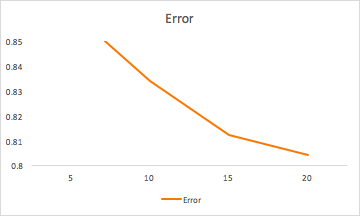

### Excercise 2: Recommender System using Apache Spark MLLIB ( 10 points)

#### Step 1: Libraries

We will need a few additional libraries for building the recommender system using mllib

1. ALS - Alternative Least Squares (ALS) with Weight Regularization algorithm for collaboritive filtering
2. RegressionEvaluator - For evaluation of the output
3. CrossValidator - For cross-validation

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 12 13:44:50 2018

@author: mundanemohit
"""

from pyspark.sql import SparkSession
#from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator

#### Step 2: Load data

We will use movieLens 10M dataset. We will use the rating dataset for this excercise.
Since we don't need timestamp, it will be removed.

In [2]:
path = '/Users/mundanemohit/Google Drive/My Work/MSc. Data Analytics/3114 Distributed Data Analytics/Excercises/Ex09/ml-10M100K/'

# Create a spark session
spark = SparkSession \
 .builder \
 .appName("Python Spark - Testing the Waters") \
 .config("spark.some.config.option", "some-value") \
 .getOrCreate()
 
sc = spark.sparkContext

# Read Data
ratingDF = spark.read.csv(path + 'ratings.dat', sep=':')
ratingDF = ratingDF.drop('_c1', '_c3', '_c5')
ratingDF = ratingDF.selectExpr('_c0 as UserID', '_c2 as MovieID', '_c4 as Rating')
ratingDF = ratingDF.withColumn('UserID', col('UserID').cast("int"))             \
                   .withColumn('MovieID', col('MovieID').cast("int"))           \
                   .withColumn('Rating', col('Rating').cast("double"))
ratingDF = ratingDF.distinct().cache()
ratingDF.show(5)
ratingDF.printSchema()

+------+-------+------+
|UserID|MovieID|Rating|
+------+-------+------+
|     3|   5505|   2.0|
|     4|    208|   3.0|
|     7|   1283|   4.5|
|     7|   4206|   3.0|
|     8|   2194|   2.5|
+------+-------+------+
only showing top 5 rows

root
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Rating: double (nullable = true)



#### Step 3: Model building 

We will use 3-fold validation with 10 iterations and regularization parameter of 0.05. 

We will use 5, 10 and 15 factors respectively for each fold.

In [4]:
# Create model with base parameters
als = ALS(maxIter=10, regParam=0.05, seed = 0,
          userCol="UserID", itemCol="MovieID", 
          ratingCol="Rating")

# Create an RMSE Evaluator
evaluator = RegressionEvaluator(predictionCol="raw", metricName="rmse")

# Set ranks for 3-fold validation
ranks = [5, 10, 15]

#### Step 4: Evaluation on test set

In [6]:
for i in range(0, len(ranks)):
    # Set rank
    als.setRank(ranks[i])
    # Split into train and test
    X_train, X_test = ratingDF.randomSplit([0.70, 0.30])
    # Fit model
    model = als.fit(X_train)    
    
    # Prediction on train set
    predictions = model.transform(X_train.select(["UserID", "MovieID"]))

    # Join to original dataset
    ratesAndPreds = X_train.join(predictions, 
                                (X_train.UserID == predictions.UserID) 
                              & (X_train.MovieID == predictions.MovieID),
                                how='inner')                            \
                          .select(X_train.Rating, predictions.prediction)
    # renaming the columns as raw and label
    ratesAndPreds = ratesAndPreds.select([col("Rating").alias("label"),col('prediction').alias("raw")])
    #ratesAndPreds = ratesAndPreds.withColumn("label", ratesAndPreds["label"].cast("float"))
    ratesAndPreds = ratesAndPreds.filter(ratesAndPreds.raw != float('nan')).cache()
               
    # calculate the error
    err = evaluator.evaluate(ratesAndPreds, {evaluator.metricName: "rmse"})
    print("Error for train-set fold ", i, "with ", ranks[i], 'factors: ', err)
    
    
    # Prediction on test set
    predictions = model.transform(X_test.select(["UserID", "MovieID"]))

    # Join to original dataset
    ratesAndPreds = X_test.join(predictions, 
                                (X_test.UserID == predictions.UserID) 
                              & (X_test.MovieID == predictions.MovieID),
                                how='inner')                            \
                          .select(X_test.Rating, predictions.prediction)
    # renaming the columns as raw and label
    ratesAndPreds = ratesAndPreds.select([col("Rating").alias("label"),col('prediction').alias("raw")])
    #ratesAndPreds = ratesAndPreds.withColumn("label", ratesAndPreds["label"].cast("float"))
    ratesAndPreds = ratesAndPreds.filter(ratesAndPreds.raw != float('nan')).cache()
               
    # calculate the error
    err = evaluator.evaluate(ratesAndPreds, {evaluator.metricName: "rmse"})
    print("Error for test-set fold ", i, "with ", ranks[i], 'factors: ', err)

Error for train-set fold  0 with  5 factors:  0.7771832360827918
Error for test-set fold  0 with  5 factors:  0.8176801987030271
Error for train-set fold  1 with  10 factors:  0.7343242105206774
Error for test-set fold  1 with  10 factors:  0.8026339992712814
Error for train-set fold  2 with  15 factors:  0.7161747845953671
Error for test-set fold  2 with  15 factors:  0.8046366017374674


Here's a comparison of results:

|Test Case           | # Factors | Iterations | Test RMSE | Train RMSE |
|--------------------|:---------:|:----------:|:---------:|:-----------|
|Movielens 1M (5-Fold) |10 |75|0.857| - |
|Fold 1 (3-Fold)       |5  |10|0.818|0.777|
|Fold 2 (3-Fold)       |10  |10|0.803|0.734|
|Fold 3 (3-Fold)       |15  |10|0.805|0.716|